# Lab 11: Sentiment analysis

- Apply VADER to hotel reviews
- Use text classification to sentiment analysis
- Add syntactic features for classification

At the end of each notebook, write a brief error analysis and  a statement of what you've learned / ideas about improvement.

In [ ]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

tqdm.pandas()

## Read data

In [ ]:
df = pd.read_parquet("/data/sentiment.parquet")
len(df)

10000

In [ ]:
df.head()

,title,review,date_stayed,date,service,cleanliness,overall,value,location,sleep_quality,rooms,locality,name,sentiment,text
4253,“Priceline Deal”,Got the Hilton for $100.00 / night on Pricelin...,October 2008,2009-08-01,4.0,4.0,4.0,4.0,4.0,NaN,4.0,San Francisco,Hilton San Francisco Fisherman's Wharf,good,“Priceline Deal” Got the Hilton for $100.00 / ...
30076,“Who could ask for anything more?”,"If you are looking for a reasonable, comfortab...",December 2007,2008-01-03,5.0,4.0,5.0,4.0,5.0,NaN,5.0,New York City,The Hampton Inn Times Square North,good,“Who could ask for anything more?” If you are ...
48047,“Lovely & sassy - a total home away from home!”,I love this hotel. Whenever I have to travel t...,August 2011,2011-09-01,5.0,5.0,5.0,4.0,NaN,5.0,NaN,Los Angeles,W Los Angeles - Westwood,good,“Lovely & sassy - a total home away from home!...
1666,“Nice Hotel”,Stayed here for 2 nights on a shopping weekend...,November 2011,2011-12-17,4.0,4.0,4.0,4.0,4.0,4.0,4.0,Seattle,Residence Inn Seattle Downtown/Lake Union,good,“Nice Hotel” Stayed here for 2 nights on a sho...
30740,“Wonderful Stay”,We stayed at the Hyatt for our anniversary. It...,August 2009,2009-10-08,3.0,4.0,4.0,4.0,2.0,NaN,4.0,Charlotte,Renaissance Charlotte SouthPark Hotel,good,“Wonderful Stay” We stayed at the Hyatt for ou...


In [ ]:
df.groupby("sentiment")["overall"].value_counts()

sentiment  overall
bad        3.0        1394
           2.0         705
           1.0         693
good       5.0        4054
           4.0        3154
Name: overall, dtype: int64

-----

## Dummy baseline

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

In [ ]:
train, test = train_test_split(
    df, test_size=0.1, stratify=df["sentiment"], random_state=619
)

In [ ]:
dummy = DummyClassifier()
dummy.fit(train["text"], train["sentiment"])
print(accuracy_score(test["sentiment"], dummy.predict(test["text"])))

0.721


-----

## VADER

In [ ]:
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

### Compound scores

VADER "compound" scores are an aggregate measure of overall sentiment. VADER uses a predefined lexicon so there's no need for "training" data.

In [ ]:
analyzer = SentimentIntensityAnalyzer()


def get_sentiment(text):
    return analyzer.polarity_scores(text)["compound"]


train["vader"] = train["text"].progress_apply(get_sentiment)
test["vader"] = test["text"].progress_apply(get_sentiment)

  0%|          | 0/9000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Highly positive reviews have high compound scores. Highly negative reviews have low compound scores on average, but there is a lot of variation.

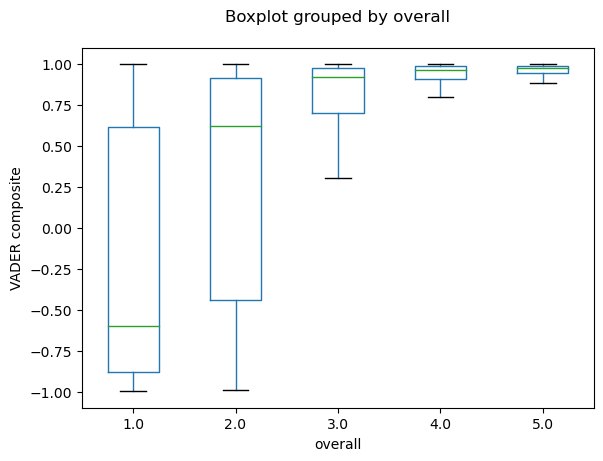

In [ ]:
train.boxplot("vader", by="overall", grid=False, showfliers=False)
plt.ylabel("VADER composite")
plt.title("")
plt.show()

Can we find a cutoff value theta, where compound>theta = good review and compound<=theta = bad review? We'll find a threshold using the training data and then test it on our test data.

In [ ]:
theta = np.linspace(-1.0, 1.0, 50)
compound = [
    accuracy_score((train["vader"] > t), (train["sentiment"] == "good")) for t in theta
]

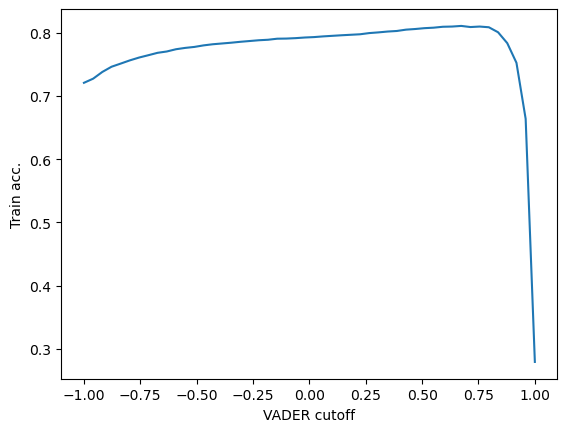

In [ ]:
plt.plot(theta, compound)
plt.xlabel("VADER cutoff")
plt.ylabel("Train acc.")
plt.show()

The peak!

In [ ]:
theta[np.argmax(compound)]

0.6734693877551019

In [ ]:
thresh = _
accuracy_score((test["vader"] > thresh), (test["sentiment"] == "good"))

0.794

Let's look at some errors:

In [ ]:
train[(train["vader"] > 0.9) & (train["sentiment"] == "bad")]["text"].iloc[0]

'“No clean rooms at 4:00 PM?” My husband and I were going to be in Charlotte for the night of July 14th. Since we had been so pleased with our stay at Hyatt Place in North Charleston, SC, we decided to give the HP at this location a try. Upon arrival at 4:00 PM (check-in is supposed to be at 3:00 PM), we were advised we would have to wait for a double room to be cleaned for our occupation. The young lady at the desk was very apologetic and kept saying her computer wasn\'t working properly. The man on the other end of her walky talky kept insisting there were several double rooms clean and available. At last, she gave us a key and sent us to the 5th floor. However, when we tried to enter the room, the maid was still working in there and told us, in very broken English, that it would be "some time" before the room would be ready. We returned to the front desk and then were sent to another room which was available and cleaned. We received coupons for a couple of free drinks at the bar and

In [ ]:
analyzer.polarity_scores(_)

{'neg': 0.039, 'neu': 0.871, 'pos': 0.09, 'compound': 0.9386}

In [ ]:
train[(train["vader"] < -0.9) & (train["sentiment"] == "good")]["text"].iloc[1]

'“Not Bad at all.” We had this hotel booked for us, for a youth trip from church. I was leary when I read the bad reviews on-line. We went with an open mind. It was clean enough, the breakfast was about normal for any hotel chain. The price was great. We had a small problem with communication on check in. The guys didnt know whose name it was under and the man at the desk had a very heavy foriegn accent, but it worked out ok. It was quiet. I didnt hear anything except some loud door slams at around 3 am. The lady that mentioned she was scared. The neighborhood was ok and the clientele was normal as far as I could tell. I have def. stayed in much worse. The only negative about the room was the small bathroom with a small vanity area--a pain with 3 tweens getting ready!'

In [ ]:
analyzer.polarity_scores(_)

{'neg': 0.158, 'neu': 0.763, 'pos': 0.079, 'compound': -0.9354}

---

## Positive/negative difference

An alternative to the compound score is to compare the % positive vs the % negative

In [ ]:
def get_diff(text):
    scores = analyzer.polarity_scores(text)
    return scores["pos"] - scores["neg"]


train["vader_diff"] = train["text"].progress_apply(get_diff)
test["vader_diff"] = test["text"].progress_apply(get_diff)

  0%|          | 0/9000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

This shows a better correlation with user ratings

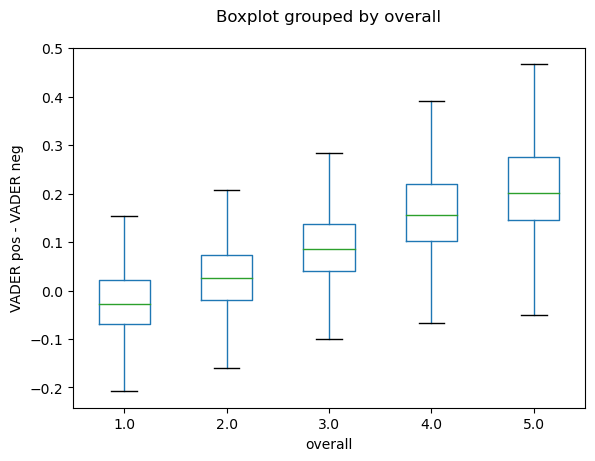

In [ ]:
train.boxplot("vader_diff", by="overall", grid=False, showfliers=False)
plt.ylabel("VADER pos - VADER neg")
plt.title("")
plt.show()

Let's look for a theshold again

Text(0, 0.5, 'Train acc.')

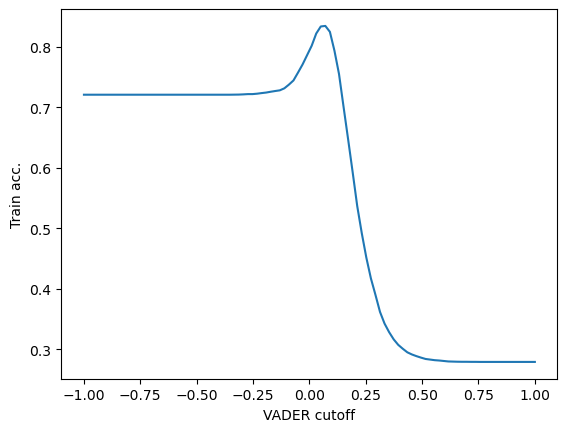

In [ ]:
theta = np.linspace(-1.0, 1.0, 100)
diff = [
    accuracy_score((train["vader_diff"] > t), (train["sentiment"] == "good"))
    for t in theta
]

plt.plot(theta, diff)
plt.xlabel("VADER cutoff")
plt.ylabel("Train acc.")

In [ ]:
thresh = theta[np.argmax(diff)]
thresh

0.07070707070707072

In [ ]:
accuracy_score((test["vader_diff"] > thresh), (test["sentiment"] == "good"))

0.846

**Observations:**
1. Although, VADER composite score means(through box plot) match the overall ratings, but it is not entirely right.
2. Even some of the 1 rated reviews have highly positive composite scores.
3. And similar for more rated reviews.
4. Getting the threshold by searching over the cut-off where we are good accuracy is a little better than the dummy classifier.
5. Where the difference between positive and negative scores seemed a better approach, and more resembles the sentiment labels, and good accuracy.
6. The errors in the reviews above are like they added their expectations and what really happened with their stay, and the information was misterpreted, as the model does not use any context.